Modèle sur mesure simple

In [20]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

# nltk
import nltk
from nltk.corpus import stopwords

import numpy as np
import os
from collections import Counter
import time

import re

import spacy
import en_core_web_sm

from sklearn.decomposition import TruncatedSVD
# Viz modules
import plotly.express as px
from sklearn.linear_model import LogisticRegressionCV

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jupiter\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
# DATASET
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [23]:
dataset_path = "data/training.1600000.processed.noemoticon.csv"
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding = "ISO-8859-1" , names= ["target", "ids", "date", "flag", "user", "text"])

Open file: data/training.1600000.processed.noemoticon.csv


In [24]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [25]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [26]:
#on récupère les données de sentiments des tweets
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

Text(0.5, 1.0, 'Dataset labels distribuition')

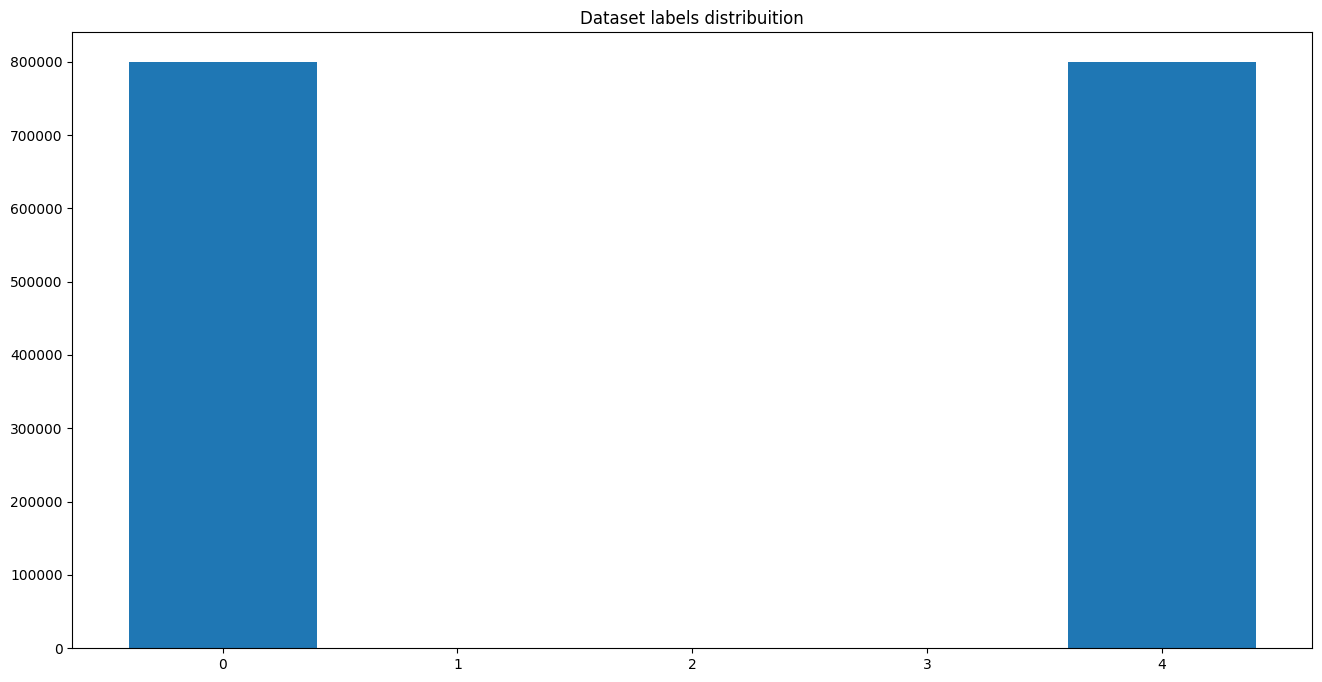

In [27]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [28]:
def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, @"
    
    #filter(lambda x:x[0]!='@', val.split())
    val = " ".join(filter(lambda x:x[0]!='@', val.split()))
    
    #filter(lambda x:x[0]!='http', val.split())
    val = " ".join(filter(lambda word: not word.startswith('http'), val.split()))
    
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    
    return sentence

def clean_dataframe(data):
    "drop nans, then apply 'clean_sentence' function to question1 and 2"
    data = data.dropna(how="any")
    
    for col in ['text']:
        data[col] = data[col].apply(clean_sentence)
    
    return data

df_cleaned = clean_dataframe(df)
df_cleaned.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww thats a bummer you shoulda got david car...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cant update his facebook by t...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,i dived many times for the ball managed to sav...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no its not behaving at all im mad why am i her...


In [29]:
df_cleaned = df_cleaned.drop(["ids", "date", "flag", "user"], axis=1)

In [30]:
df_cleaned

,target,text
0,0,awww thats a bummer you shoulda got david car...
1,0,is upset that he cant update his facebook by t...
2,0,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like its on fire
4,0,no its not behaving at all im mad why am i her...
...,...,...
1599995,4,just woke up having no school is the best feel...
1599996,4,thewdbcom very cool to hear old walt intervie...
1599997,4,are you ready for your mojo makeover ask me fo...
1599998,4,happy 38th birthday to my boo of alll time tup...


In [41]:
# Download resources
nltk.download("stopwords")
#stopwords = set(stopwords.words("english"))
stopwords_nltk = nltk.corpus.stopwords
stopwords = stopwords_nltk.words('english')

# Download SpaCy model
nlp = en_core_web_sm.load()

# Define tokenizer
tokenizer = lambda text: [  # SpaCy Lemmatizer
    token.lemma_.lower() for token in nlp(text) if token.is_alpha and not token.is_stop
]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jupiter\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
 # Define vectorizer
vectorizer = TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
        tokenizer=tokenizer,
    )


# Vectorize text
X = vectorizer.fit_transform(df.text)

# Get vocabulary
vocabulary = vectorizer.get_feature_names_out()

In [44]:
# Train LSA model
n_components = 50
lsa = TruncatedSVD(n_components=n_components, random_state=42).fit(X)

In [45]:
# Reduce dimensionality
X_lsa = lsa.transform(X)

X_lsa.shape

(1600000, 50)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X_lsa,
    df.target,
    test_size=0.2,
    stratify=df.target,
    random_state=42,
)

In [47]:
# Define model
model = LogisticRegressionCV(random_state=42)

# Train model
model.fit(X_train, y_train)

LogisticRegressionCV(random_state=42)

In [48]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

In [49]:
y_pred = model.predict(X_test)

Text(50.722222222222214, 0.5, 'y_pred')

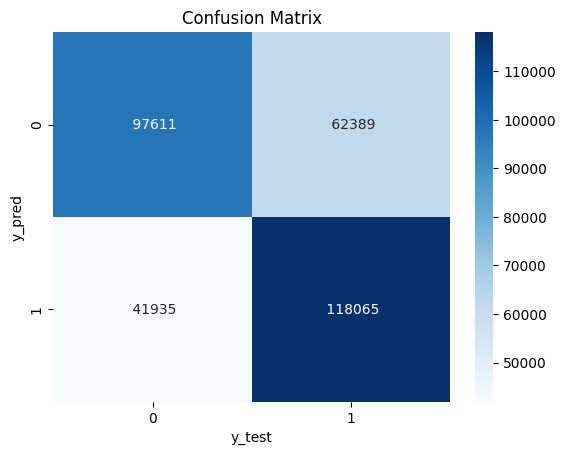

In [50]:
cm=confusion_matrix(y_test,y_pred)
ax=sns.heatmap(cm,annot=True,cmap='Blues',fmt=' ')
ax.set_title('Confusion Matrix')
ax.set_xlabel('y_test')
ax.set_ylabel('y_pred')

In [51]:
#0.68 accurracy

In [60]:
import pandas as pd


from sklearn.metrics import recall_score
recall=recall_score(y_test, y_pred, pos_label=4)
from sklearn.metrics import precision_score
precision=precision_score(y_test, y_pred, pos_label=4)
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_test, y_pred)

df = pd.DataFrame({'Nom du modèle': ['Modèle Regression Logistic'], 'Recall': [recall], 'Precision': [precision], 'Accuracy': [accuracy]})

df

#export de la donnée en csv 
df.to_csv('models_results/model_regression_logistic_df.csv')


In [61]:
df

,Nom du modèle,Recall,Precision,Accuracy
0,Modèle Regression Logistic,0.737906,0.654266,0.673987


In [ ]:
#construire les tokens tf-idf puis logistsic regrsseion 
#vectorizer les text avec tf idf

In [ ]:
from gensim.utils import tokenize
sentance = [list(tokenize(s, deacc=True, lower=True)) for s in df_cleaned['text']]
sentance[0]

In [ ]:
from gensim.models import word2vec
model = word2vec.Word2Vec(sentance, window=20, min_count=2, workers=1, 
                          )
model.corpus_count

In [ ]:
from gensim.models.word2vec import Word2Vec


word2vec = Word2Vec(sentance)
word2vec.wv.most_similar(["burger"], topn=20)

In [ ]:
'''from sklearn.manifold import TSNE


X_w2v = [word2vec.wv[x] for x in word2vec.wv.key_to_index.keys()]
X_tsne = TSNE(random_state=42).fit_transform(X_w2v)

fig = px.scatter(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    text=word2vec.wv.key_to_index.keys(),
    labels={"x": "Component 1", "y": "Component 2"},
    title="Word2Vec TSNE",
)
fig.show()'''

In [ ]:
#calculer l'accuracy

#modèle avancé
#au lieu de tf idf il faut utiliser d'autre ectorisation => Word Embedding(word2vec, glov, et fastext) en prendre deux 
#et les combiner avec un layer lstm pour créer deux modèle de deeplearning
#et les utiliser comme input d'un modèle pour ensuite les comparer

In [ ]:
i = 456